In [1]:
import os
import zipfile
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFAlbertModel

In [2]:
data_root = '../../data/'
local_zip = data_root + 'msra.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('../../data/')
zip_ref.close()

In [3]:
def get_data_path(data_dir=data_root + 'msra/', type='train'):
    if type in ['train', 'val', 'test']:
        sentences_path = os.path.join(data_dir, type, 'sentences.txt')
        tags_path = os.path.join(data_dir, type, 'tags.txt')
        return sentences_path, tags_path
    else:
        raise ValueError("data type not in ['train', 'val', 'test']")


In [4]:
max_len = 128
batch_size = 32
model_name = 'clue/albert_chinese_tiny'
saved_model = 'ner_albert_tiny_token_input'

In [5]:
class Label_Tokenizer(object):
    def __init__(self, labels, max_length):
        super().__init__()
        self.size = len(labels)
        labels_to_ids = {k: v for v, k in enumerate(labels)}
        ids_to_labels = {v: k for v, k in enumerate(labels)}
        self.labels_to_ids = labels_to_ids
        self.ids_to_labels = ids_to_labels
        self.max_length = max_length

    def tokenize(self, labels):
        tokens = [self._tokenize(label) for label in labels]
        return tokens

    def _tokenize(self, label):
        label = label.decode('utf-8') if hasattr(label, 'decode') else label
        labels = [le for le in label.strip().split(' ')]
        special_token = self.encode(['O'])[0]

        tokens = self.encode(labels)
        tokens = tokens[:self.max_length - 2]
        tokens = [special_token] + tokens + [special_token]
        # Add padded TAG tokens
        padding_len = self.max_length - len(tokens)
        tokens = tokens + ([special_token] * padding_len)
        return tokens

    def encode(self, labels):
        return [self.labels_to_ids[label] for label in labels]

    def decode(self, ids):
        return [self.ids_to_labels[id] for id in ids]


In [6]:
labels = ['O', 'B-ORG', 'I-PER', 'B-PER', 'I-LOC', 'I-ORG', 'B-LOC']
label_tokenizer = Label_Tokenizer(labels, max_length=max_len)
labels_num = label_tokenizer.size

In [7]:
class Sentence_Tokenizer(object):
    def __init__(self, model_name, max_length=128, padded_token=True):
        super().__init__()
        self.max_length = max_length
        self.padded_token = padded_token
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
    
    def bert_pack_inputs(self, sentences):
        input_ids = []
        attention_masks = []
        token_type_ids = []
        for sentence in sentences:
            tokens = self.tokenize(sentence, self.padded_token)
            input_ids.append(tokens['input_ids'])
            attention_masks.append(tokens['attention_mask'])
            token_type_ids.append(tokens['token_type_ids'])
        return [tf.constant(input_ids), tf.constant(token_type_ids), tf.constant(attention_masks)]
    
    def tokenize(self, sentence, padded_token=True):
        padiding = 'max_length' if padded_token else True
        tokens = self.tokenizer(text=sentence.strip(), max_length=self.max_length, truncation=True, padding=padiding, add_special_tokens=True)
        return tokens
    
    def decode(self, tokens):
        words = self.tokenizer.decode(tokens)
        return words

In [8]:
tokenizer = Sentence_Tokenizer(model_name, max_length=max_len)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [9]:
def get_type_data(type, max_lines=None):
  sentences_file, labels_file = get_data_path(type=type)
  sentences = tf.data.TextLineDataset(sentences_file).prefetch(tf.data.experimental.AUTOTUNE)
  if(max_lines != None):
    sentences = sentences.take(max_lines)
  x = [sentence.decode('utf-8') for sentence in sentences.as_numpy_iterator()]
  x = tokenizer.bert_pack_inputs(x)

  labels = tf.data.TextLineDataset(labels_file).prefetch(tf.data.experimental.AUTOTUNE)
  if(max_lines != None):
    labels = labels.take(max_lines)
  labels = [label.decode('utf-8') for label in labels.as_numpy_iterator()]
  y = label_tokenizer.tokenize(labels)
  y = tf.constant(y)
  print(len(y))
  return x, y

def get_dataset(max_lines=None):
  val_max_lines = None
  if(max_lines != None):
    val_max_lines = int(max_lines / 10)
  train = get_type_data('train', max_lines)
  val = get_type_data('val', val_max_lines)
  test = get_type_data('test', val_max_lines)
  return train, val, test

In [10]:
train, val, test = get_dataset(16000)
x_train, y_train = train
x_val, y_val = val
x_test, y_test = test

2022-06-20 23:34:28.967065: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


16000
1600
1600


In [11]:
def create_model(labels_num, max_lenth):
    input_ids = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)
    token_type_ids = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)
    attention_mask = keras.layers.Input(shape=(max_lenth,), dtype=tf.int32)

    encoder = TFAlbertModel.from_pretrained(model_name, from_pt=True)
    outputs = encoder(
        input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )

    embedding = outputs[0]
    embedding = keras.layers.Dropout(0.3)(embedding)
    tag_logits = keras.layers.Dense(
        labels_num + 1, activation='softmax', name='NER')(embedding)
    
    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[tag_logits],
    )
    optimizer = keras.optimizers.Adam(learning_rate=3e-5)
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics=tf.metrics.SparseCategoricalAccuracy(name='accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


In [12]:
model = create_model(labels_num, max_lenth=max_len)
model.summary()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  4080520    ['input_1[0][0]',                
 )                              thPooling(last_hidd               'input_3[0][0]',            

In [13]:
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=3,
    verbose=1,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)


Epoch 1/3


/Users/mng/miniforge3/envs/c3-nlp/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


500/500 [==============================] - 249s 496ms/step - loss: 0.1054 - accuracy: 0.9689 - val_loss: 0.0392 - val_accuracy: 0.9875
Epoch 2/3
500/500 [==============================] - 251s 502ms/step - loss: 0.0358 - accuracy: 0.9883 - val_loss: 0.0303 - val_accuracy: 0.9905
Epoch 3/3
500/500 [==============================] - 255s 510ms/step - loss: 0.0266 - accuracy: 0.9913 - val_loss: 0.0264 - val_accuracy: 0.9916


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


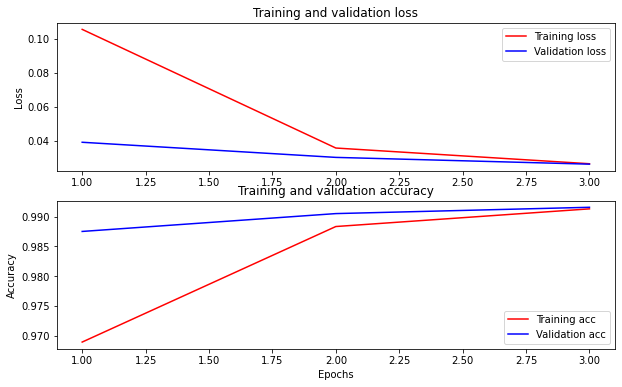

In [14]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [15]:
loss, accuracy = model.evaluate(x_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

50/50 [==============================] - 12s 232ms/step - loss: 0.0332 - accuracy: 0.9898
Loss: 0.0331692211329937
Accuracy: 0.9898340106010437


In [16]:
def predict_from_text(text, model):
    n_tokens = len(tokenizer.tokenize(text, padded_token=False)['input_ids'])
    tokens = tokenizer.bert_pack_inputs([text])
    x_test = tokens
    pred_test = model.predict(x_test) if hasattr(model, 'predict') else model(x_test)
    # ignore predictions of padding tokens
    pred_tags = np.argmax(pred_test, 2)[0][:n_tokens]

    tags = label_tokenizer.decode(pred_tags)
    res = []
    words = {
        'word': '',
        'tag': None
    }
    for idx, tag in enumerate(tags):
        if(tag != 'O'):
            pre, suf = tag.split('-')
            words['tag'] = suf
            token = x_test[0][0][idx]
            token = token.numpy()
            word = tokenizer.decode(token)
            # word = preprocessor.decode(word)
            words['word'] = words['word'] + word if words['word'] else word
        else:
            if(words['tag']):
                res.append(words)
            words = {
                'word': '',
                'tag': None
            }
    return pd.DataFrame(res)


In [17]:
test_inputs = '李华住在朝阳区香河园街道西坝河北里社区，在5月4号去过天安门广场，5号下午去了太阳宫凯德茂商场。'

In [18]:
print(predict_from_text(test_inputs, model))


              word  tag
0               李华  PER
1  朝阳区香河园街道西坝河北里社区  LOC
2            天安门广场  LOC
3         太阳宫凯德茂商场  LOC


In [19]:
model.save(saved_model, include_optimizer=False)


2022-06-20 23:47:31.276317: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ner_albert_tiny_token_input/assets


INFO:tensorflow:Assets written to: ner_albert_tiny_token_input/assets
